In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
#To obtain the Light Curve Data we search the MAST Database using lightkurve library.
import lightkurve as lk

In [8]:
#We read the RV datafile of TOI-2431.
df_rv_raw = pd.read_csv('../../data/rvdata/TIC 258804746_rv_bin.csv')

#We also add another column called "tel" to these DataFrames.
#This describes the instrument that was used to obtain these data.
df_rv_raw['tel'] = ['MERCATOR' for i in range(len(df_rv_raw))]

#We only take "bjd", "rv", "e_rv" and "tel" columns from the df_all as follows. (We basically remove other columns)
df_rv = df_rv_raw[['bjd','rv','e_rv','tel']]

#Then we define those columns as "time", "mnvel", "errvel" and "tel" as follows.
df_rv.columns = ['time','mnvel','errvel','tel']

df_rv

time      mnvel    errvel       tel
0  2.460662e+06 -12.153412  2.790352  MERCATOR
1  2.460662e+06 -26.195315  3.368164  MERCATOR
2  2.460664e+06  -7.562243  2.513292  MERCATOR
3  2.460665e+06   1.563915  1.954405  MERCATOR
4  2.460666e+06   6.679098  1.907049  MERCATOR
5  2.460681e+06 -22.781483  4.561505  MERCATOR
6  2.460681e+06  -2.585665  3.008596  MERCATOR

In [9]:
t_rv = df_rv_raw.bjd.values
rv = df_rv_raw.rv.values
e_rv = df_rv_raw.e_rv.values

In [10]:
#We get the Light Curve Data of TOI-2431.
#Note that the exposure time should be in seconds.
target = "TOI-2431"
data_search = lk.search_lightcurve(target, exptime = 120)

data_search

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 31 2020   SPOC     120   258804746      0.0
  1 TESS Sector 42 2021   SPOC     120   258804746      0.0
  2 TESS Sector 43 2021   SPOC     120   258804746      0.0
  3 TESS Sector 70 2023   SPOC     120   258804746      0.0
  4 TESS Sector 71 2023   SPOC     120   258804746      0.0

In [11]:
#We select the Light Curve Data.
selected_lc_data = data_search[1]

selected_lc_data

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 42 2021   SPOC     120   258804746      0.0

In [12]:
#We download that Light Curve Data as follows.
lc_data = selected_lc_data.download()

lc_data

<TessLightCurve length=17367 LABEL="TIC 258804746" SECTOR=42 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
2447.6930320573024  2.5366594e+04 ...  4.0460769e-02  1.3607827e-02
2447.6944210817496  2.5396891e+04 ...  3.9038315e-02  2.4389252e-02
 2447.695810106197  2.5387309e+04 ...  3.6639728e-02  2.3775060e-02
 2447.697199130412  2.5413061e+04 ...  4.2005081e-02  2.0878419e-02
 2447.698588154859  2.5379848e+04 ...  3.4780011e-02  2.5321519e-02
2447.6999771793057  2.5412535e+04 ...  4.0004041e-02  1.6409431e-02
 2447.701366203521  2.5413562e+04 ...  3.7120342e-02  2.4003871e-02
2447.7027552279683  2.5404645e+04 ...  3.8214486e-02  2.4323924e-02
2447.7041442521827  2.5377213e+04 ...  4.0465172e-02  2.9530717e-02
               ...            ... ...            ...            ...
2473.1520299381887            ——— ...            ———            ———
 2473.153418922822            ——— ...            ———            ———
 2473.154807907456            ——— ...            ———            ———
 2473.156196892089            ——— ...            ———            ———
 2473.157585877189            ——— ...            ———            ———
 2473.158974861822            ——— ...            ———            ———
2473.1603638464544            ——— ...            ———            ———
2473.1617528310876            ——— ...            ———            ———
2473.1631418161865            ——— ...            ———            ———

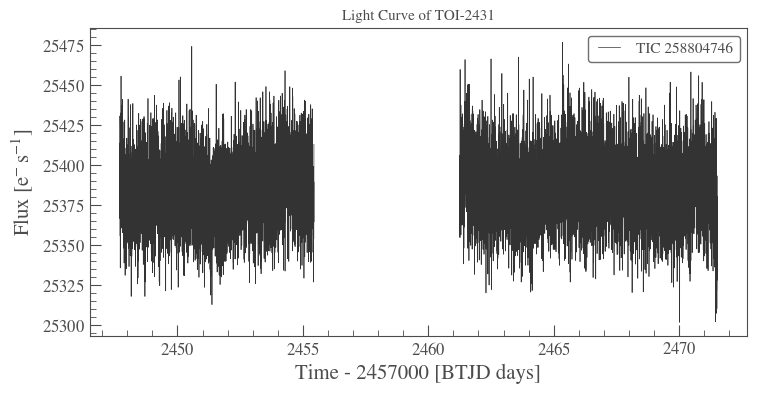

In [13]:
#Then we can plot the Light Curve Data as follows.
lc_data.plot()
plt.title(f"Light Curve of {target}")
plt.show()

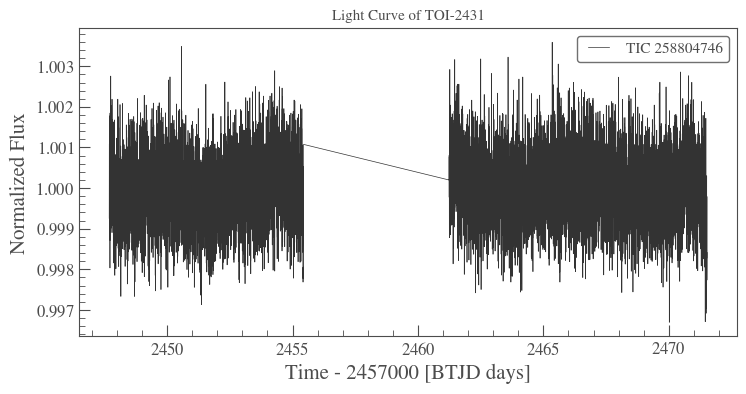

In [14]:
#We remove "Not a Number (NaN) values, then normalize the Fluxes to 1 as follows"
lc = lc_data[lc_data.flux.value > 0].remove_nans().normalize()

#Then our Light Curve becomes the following.
lc.plot()
plt.title(f"Light Curve of {target}")
plt.show()

In [15]:
#We then define raw datas of time, flux and flux error as arrays.
t_lc = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value

#We mask out the values depending on the quality value.
quality = lc.quality.value
mask = quality == 0

In [16]:
#Then we create a dataframe with the masked values.
df_lc = pd.DataFrame()
df_lc["time"] = t_lc[mask]
df_lc["flux"] = flux[mask]
df_lc["flux_err"] = flux_err[mask]

df_lc

time      flux  flux_err
0      2447.693032  0.999257  0.000775
1      2447.694421  1.000450  0.000775
2      2447.695810  1.000073  0.000775
3      2447.697199  1.001087  0.000775
4      2447.698588  0.999779  0.000775
...            ...       ...       ...
12959  2471.517197  0.999792  0.000836
12960  2471.518586  0.997734  0.000836
12961  2471.519975  0.998159  0.000836
12962  2471.521364  0.998140  0.000837
12963  2471.522753  0.998414  0.000837

[12964 rows x 3 columns]

In [17]:
#From here we can get the time, flux and flux error as arrays.
t_lc = df_lc.time.values
flux = df_lc.flux.values
flux_err = df_lc.flux_err.values.filled(np.nan)

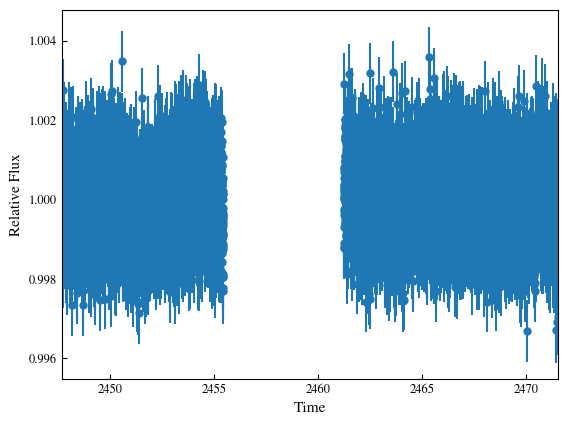

In [18]:
#Now we plot the Phase-Folded Light Curve.
#Note that we need to convert "MaskedNDArray" type into regular numpy arrays when it comes to plotting the errorbar.
#That's why, we use .filled(np.nan) for the "flux_err" Masked N-Dimension Array (MaskedNDArray).
plt.errorbar(t_lc, flux, flux_err, fmt="o")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)

#To see the transit more clear for this target, we limit x i.e. the time to maximum and minimum time value we have.
plt.xlim(min(t_lc),max(t_lc))
plt.show()

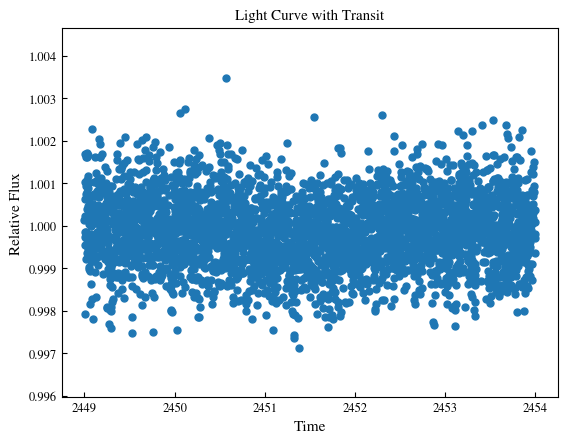

In [19]:
#We create a mask to remove the parts where there is no transit.
mask = (t_lc >= 2449) & (t_lc <= 2454)

#We then apply this mask to our arrays.
#phase = phase[mask]
t_lc = t_lc[mask]
flux = flux[mask]
flux_err = flux_err[mask]

#We then plot the parts with transit as follows.
plt.errorbar(t_lc, flux, flux_err, fmt="o", label="Transit data", elinewidth=0)
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.title("Light Curve with Transit")
plt.show()

In [20]:
#For joint fitting to work, we need to define a dictionary that will store both LC and RV data.
inputdata = {}

#We add the RV times, velocities and velocity errors.
inputdata["time_rv1"] = df_rv.time.values
inputdata["rv_rv1"] = df_rv.mnvel.values
inputdata["e_rv1"] = df_rv.errvel.values

#We add the Transit times, fluxes and the flux errors.
inputdata["time_tr1"] = df_lc.time.values
inputdata["f_tr1"] = df_lc.flux.values.filled(np.nan)
inputdata["e_tr1"] = df_lc.flux_err.values.filled(np.nan)

inputdata

{'time_rv1': array([2460661.69433389, 2460661.83431901, 2460663.81847674,
        2460664.63461718, 2460665.58386928, 2460680.64476996,
        2460680.74656597]),
 'rv_rv1': array([-12.15341225, -26.19531535,  -7.56224319,   1.56391486,
          6.67909776, -22.7814826 ,  -2.5856654 ]),
 'e_rv1': array([2.79035229, 3.3681642 , 2.51329169, 1.95440451, 1.90704861,
        4.56150459, 3.00859567]),
 'time_tr1': array([2447.69303206, 2447.69442108, 2447.69581011, ..., 2471.51997508,
        2471.52136407, 2471.52275305]),
 'f_tr1': array([0.99925655, 1.00045   , 1.0000726 , ..., 0.9981592 , 0.99814034,
        0.9984135 ], dtype=float32),
 'e_tr1': array([0.00077483, 0.00077498, 0.00077502, ..., 0.00083606, 0.00083653,
        0.00083701], dtype=float32)}

In [21]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/utils.py'>)

In [22]:
#We get the Prior File for the target we are analyzing as follows.
#Please open one of the .txt files to see how to setup the Prior Files.
f = '../../data/lcrvpriors/TOI2431b_priorNewData.txt'
reload(gaiafitwithtransit)

#We then use "LPFunctionRVOnly" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunction1RV1Phot(inputdata,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.RMFit(L)

Reading in priorfile from ../../data/lcrvpriors/TOI2431b_priorNewData.txt
   prior          arg1          arg2        label  description priortype  \
0     NP  6.400000e-01  8.469820e-02        mstar        mstar     model   
1     NP  2.241958e-01  5.480000e-08         P_p1         P_p1     model   
2     FP  9.000000e+01  9.000000e+01       inc_p1       inc_p1     model   
3     UP  1.200000e+00  5.000000e+00         a_p1         a_p1     model   
4     NP  2.460259e+06  2.817369e-03        t0_p1        t0_p1     model   
5     FP  0.000000e+00  0.000000e+00       ecc_p1       ecc_p1     model   
6     FP  9.000000e+01  9.000000e+01     omega_p1     omega_p1     model   
7     NP  4.742543e-01  1.946948e-01         b_p1         b_p1     model   
8     NP  2.096097e-02  8.676171e-04         p_p1         p_p1     model   
9     NP  2.920000e-01  2.600000e-02      tdur_p1      tdur_p1     model   
10    UP  1.000000e-01  1.000000e+00           u1           u1     model   
11    UP  1.00

In [23]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=2000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
       labels       centers         lower         upper            pv   center_dist
0       mstar  6.400000e-01  2.165090e-01  1.063491e+00  7.181225e-01 -7.812250e-02
1        P_p1  2.241958e-01  2.241955e-01  2.241961e-01  2.241957e-01  8.797026e-08
2        a_p1  3.100000e+00  1.200000e+00  5.000000e+00  3.994418e+00 -8.944177e-01
3       t0_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06  3.386639e-03
4        b_p1  4.742543e-01 -4.992195e-01  1.447728e+00  6.864282e-01 -2.121738e-01
5        p_p1  2.096097e-02  1.662288e-02  2.529906e-02  2.096765e-02 -6.683786e-06
6     tdur_p1  2.920000e-01  1.620000e-01  4.220000e-01  2.488912e-01  4.310882e-02
7          u1  5.500000e-01  1.000000e-01  1.000000e+00  5.562466e-01 -6.246551e-03
8          u2  5.500000e-01  1.000000e-01  1.000000e+00  6.101548e-01 -6.015479e-02
9        K_p1  2.500000e+01  0.000000e+00  5.000000e+01  2.296161e+01  2.038391e+00
10  gamma_rv1 

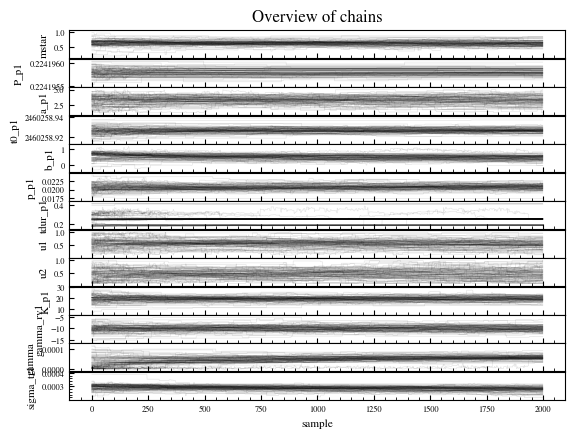

In [24]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [25]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

mstar      P_p1      a_p1         t0_p1      b_p1      p_p1  \
0      0.554290  0.224196  3.923496  2.460259e+06  0.525762  0.020848   
1      0.554290  0.224196  3.923496  2.460259e+06  0.525762  0.020848   
2      0.554290  0.224196  3.923496  2.460259e+06  0.525762  0.020848   
3      0.554290  0.224196  3.923496  2.460259e+06  0.525762  0.020848   
4      0.554290  0.224196  3.923496  2.460259e+06  0.525762  0.020848   
...         ...       ...       ...           ...       ...       ...   
99995  0.855175  0.224196  4.063100  2.460259e+06  0.326721  0.019647   
99996  0.855175  0.224196  4.063100  2.460259e+06  0.326721  0.019647   
99997  0.855175  0.224196  4.063100  2.460259e+06  0.326721  0.019647   
99998  0.855175  0.224196  4.063100  2.460259e+06  0.326721  0.019647   
99999  0.855175  0.224196  4.063100  2.460259e+06  0.326721  0.019647   

        tdur_p1        u1        u2       K_p1  gamma_rv1     gamma  sigma_tr1  
0      0.252040  0.597016  0.170588  18.727367  -8.233733  0.000070   0.000273  
1      0.252040  0.597016  0.170588  18.727367  -8.233733  0.000070   0.000273  
2      0.252040  0.597016  0.170588  18.727367  -8.233733  0.000070   0.000273  
3      0.252040  0.597016  0.170588  18.727367  -8.233733  0.000070   0.000273  
4      0.252040  0.597016  0.170588  18.727367  -8.233733  0.000070   0.000273  
...         ...       ...       ...        ...        ...       ...        ...  
99995  0.258035  0.464514  0.971542  20.497039  -9.872210  0.000053   0.000231  
99996  0.258035  0.464514  0.971542  20.497039  -9.872210  0.000053   0.000231  
99997  0.258035  0.464514  0.971542  20.497039  -9.872210  0.000053   0.000231  
99998  0.258035  0.464514  0.971542  20.497039  -9.872210  0.000053   0.000231  
99999  0.258035  0.464514  0.971542  20.497039  -9.872210  0.000053   0.000231  

[100000 rows x 13 columns]

In [26]:
#We calculate the Planet Mass using the posteriors K, Mstar, P and Eccentricity.
df_post['mp'] = utils.msini_from_rvs(df_post["K_p1"].values,
                                     m_1=0.640,
                                     P=df_post["P_p1"].values,
                                     e=0,
                                     i=90)

df_post["mp"]

0        0.041571
1        0.041571
2        0.041571
3        0.041571
4        0.041571
           ...   
99995    0.045499
99996    0.045499
99997    0.045499
99998    0.045499
99999    0.045499
Name: mp, Length: 100000, dtype: float64

In [27]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                     values
0      mstar                  $0.635_{-0.078}^{+0.077}$
0       P_p1  $0.224195795_{-0.00000006}^{+0.00000008}$
0       a_p1                     $3.33_{-0.74}^{+0.64}$
0      t0_p1         $2460258.9266_{-0.0022}^{+0.0026}$
0       b_p1                      $0.5_{-0.16}^{+0.14}$
0       p_p1            $0.02074_{-0.00074}^{+0.00077}$
0    tdur_p1                $0.2532_{-0.065}^{+0.0028}$
0         u1                     $0.55_{-0.16}^{+0.14}$
0         u2                     $0.48_{-0.19}^{+0.20}$
0       K_p1                       $19.4_{-2.2}^{+2.0}$
0  gamma_rv1                      $-10.0_{-1.1}^{+1.2}$
0      gamma          $5.57e-05_{-0.000010}^{+0.00001}$
0  sigma_tr1           $0.000286_{-0.00002}^{+0.00001}$

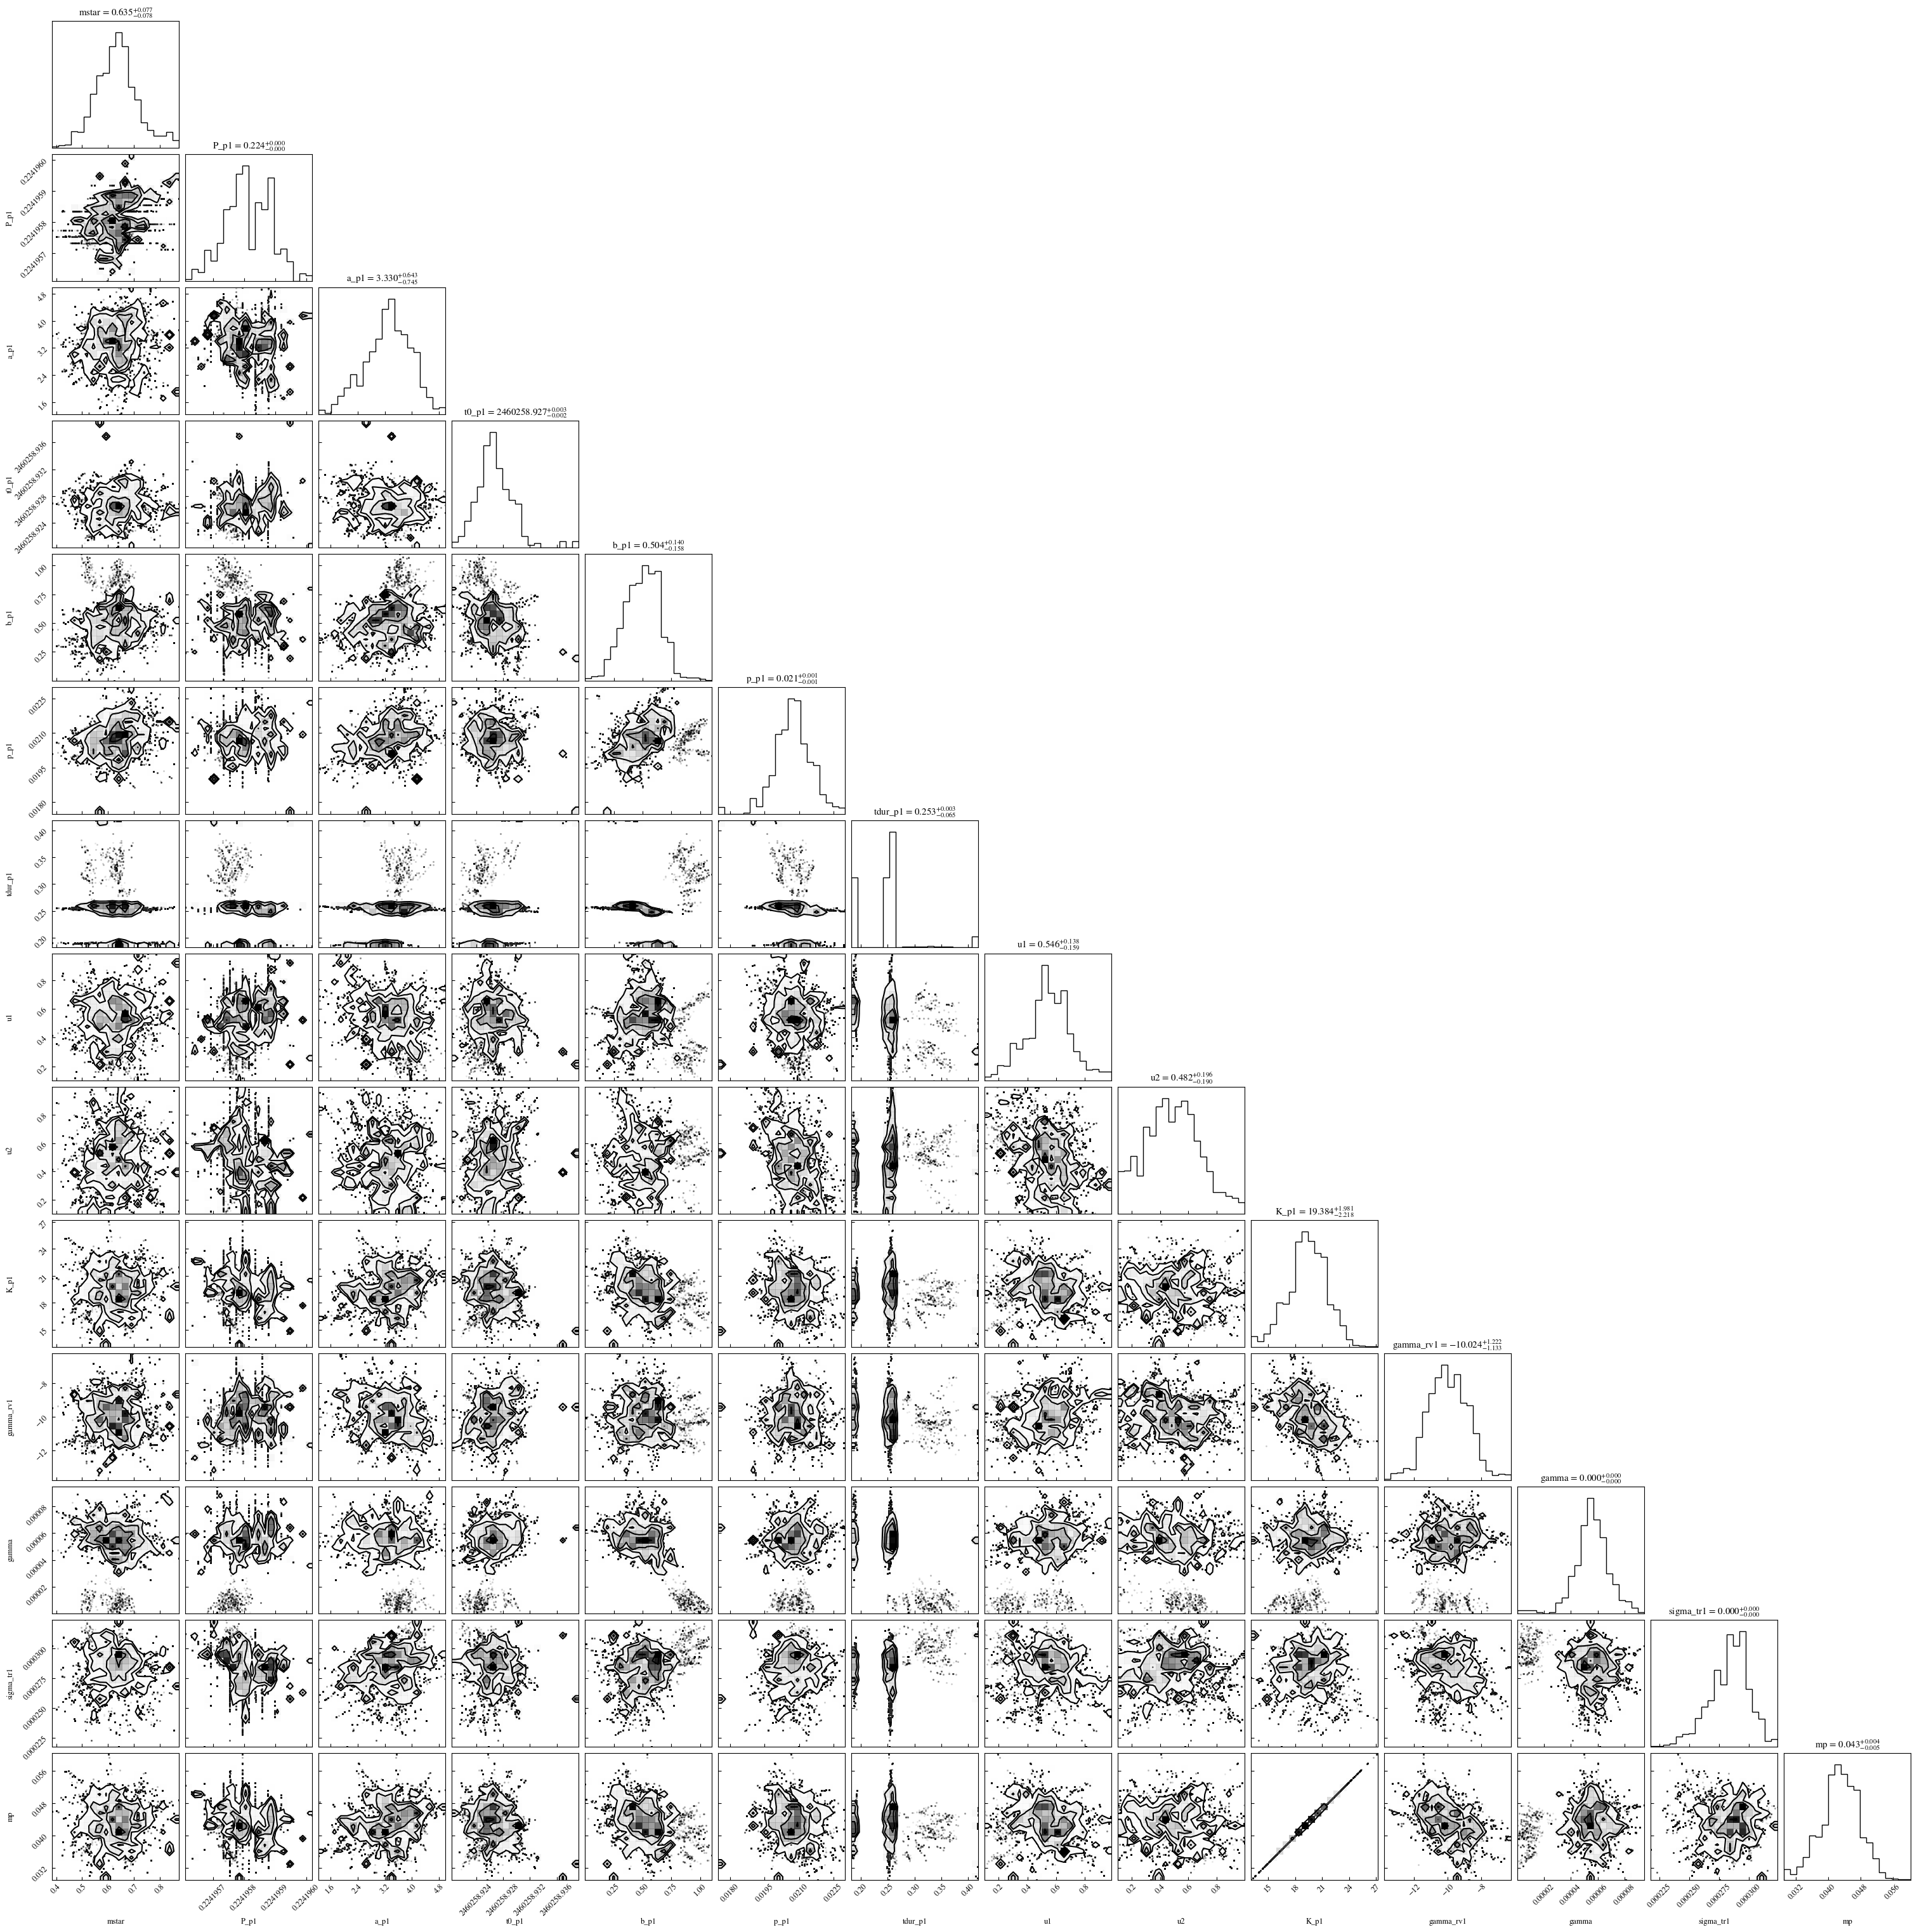

In [28]:
#We then plot the Corner Plot.
import corner
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

#We then need to access the figure axes in order to obtain the planet mass.
axes = fig.get_axes()

#Now we look for the planet mass using the titles of the corner plot.
mp_title = None
for ax in axes:
    title = ax.get_title() 
    if 'mp' in title:
        mp_title = title
        break

#We show the corner plot.
plt.show();

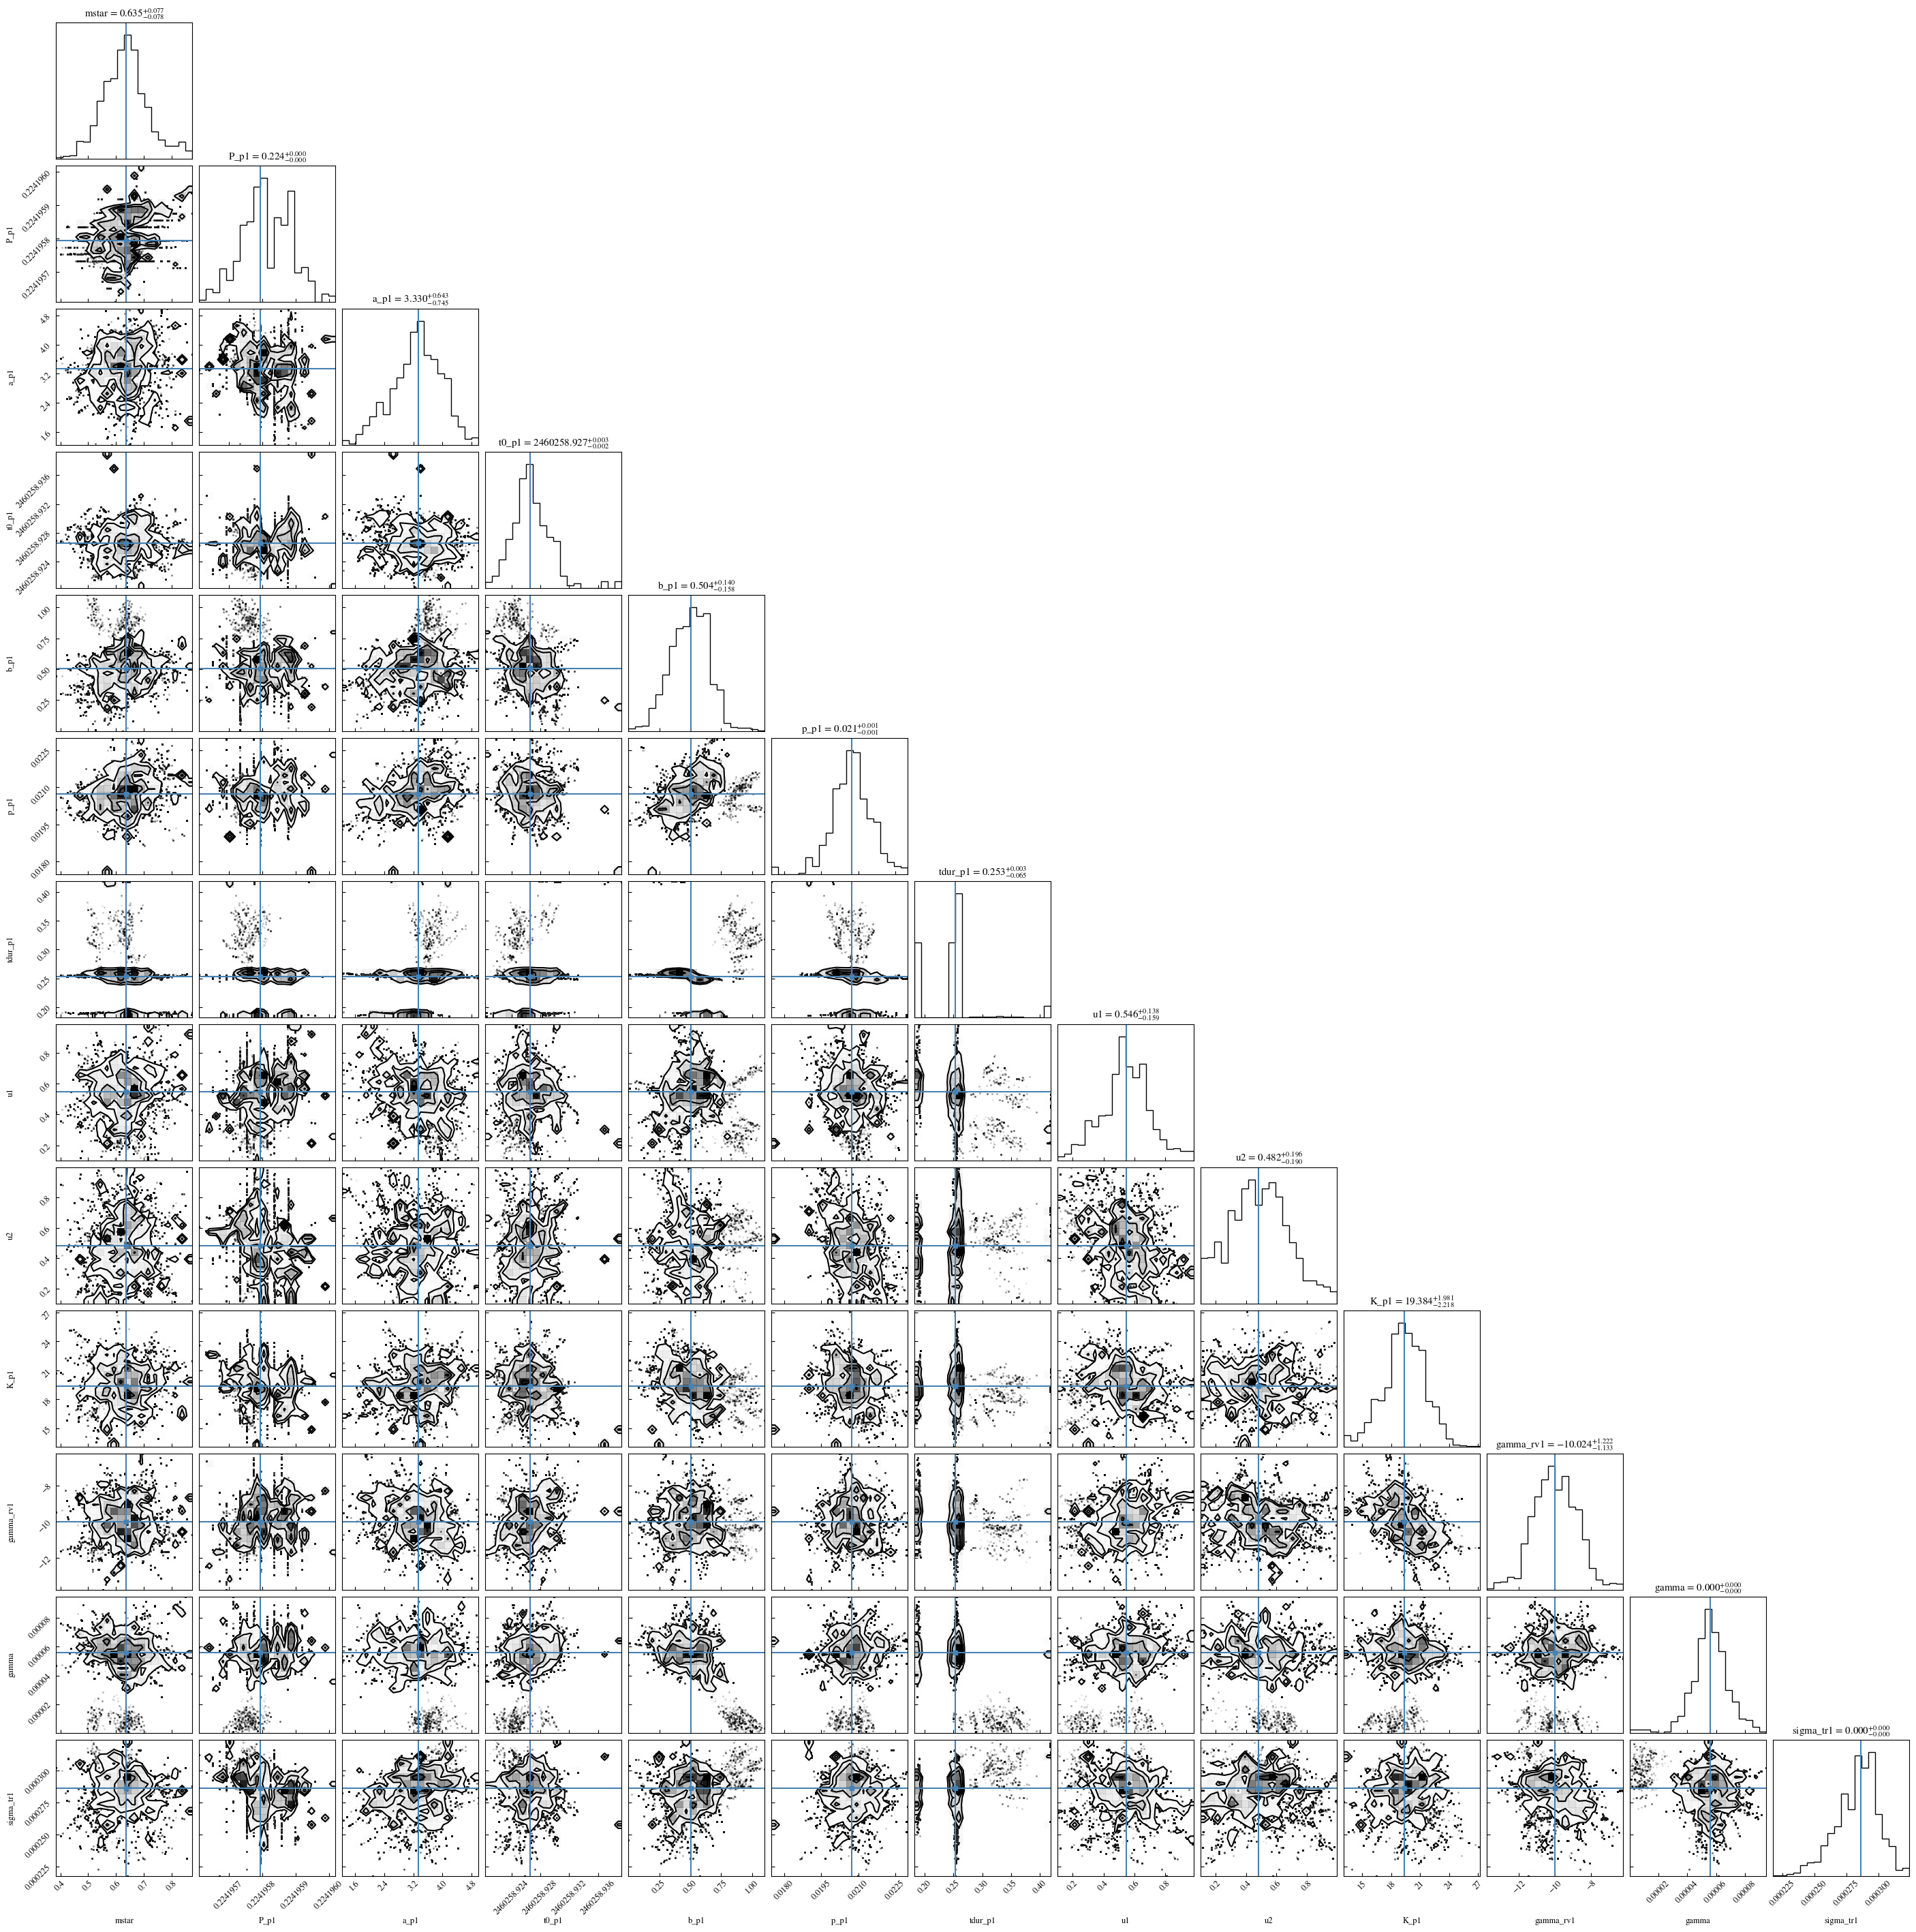

In [29]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.iloc[:, :-1].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :-1].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

In [30]:
#We get the Mass from the MCMC chains to convert it to Earth Mass values.
# obj = [df_medvals[df_medvals.Labels=='mp']['values'].values[0]]
obj = mp_title

#We then extract the numbers and remove the $ and {} characters
cleaned_str = obj.replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('mp = ', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value, lower_error, upper_error = cleaned_str.split('-')[0], cleaned_str.split('-')[1].split('+')[0], cleaned_str.split('+')[1]
lower_error = lower_error.replace('^', '')
upper_error = upper_error.replace('^', '')

#Now we convert all of them to floats and multiply them Earth Mass factor. (1 M_Jupiter = 317.83 M_Earth)
factor = 317.83
central_value = float(central_value) * factor
lower_error = float(lower_error) * factor
upper_error = float(upper_error) * factor

#We then format it back to the original string from the output.
mass_converted = f"${central_value:.3f}_{{-{lower_error:.3f}}}^{{+{upper_error:.3f}}}$"
print(mass_converted)

$13.667_{-1.589}^{+1.271}$


Sampling, i= 0
Sampling, i= 100
Sampling, i= 200
Sampling, i= 300
Sampling, i= 400
Sampling, i= 500
Sampling, i= 600
Sampling, i= 700
Sampling, i= 800
Sampling, i= 900


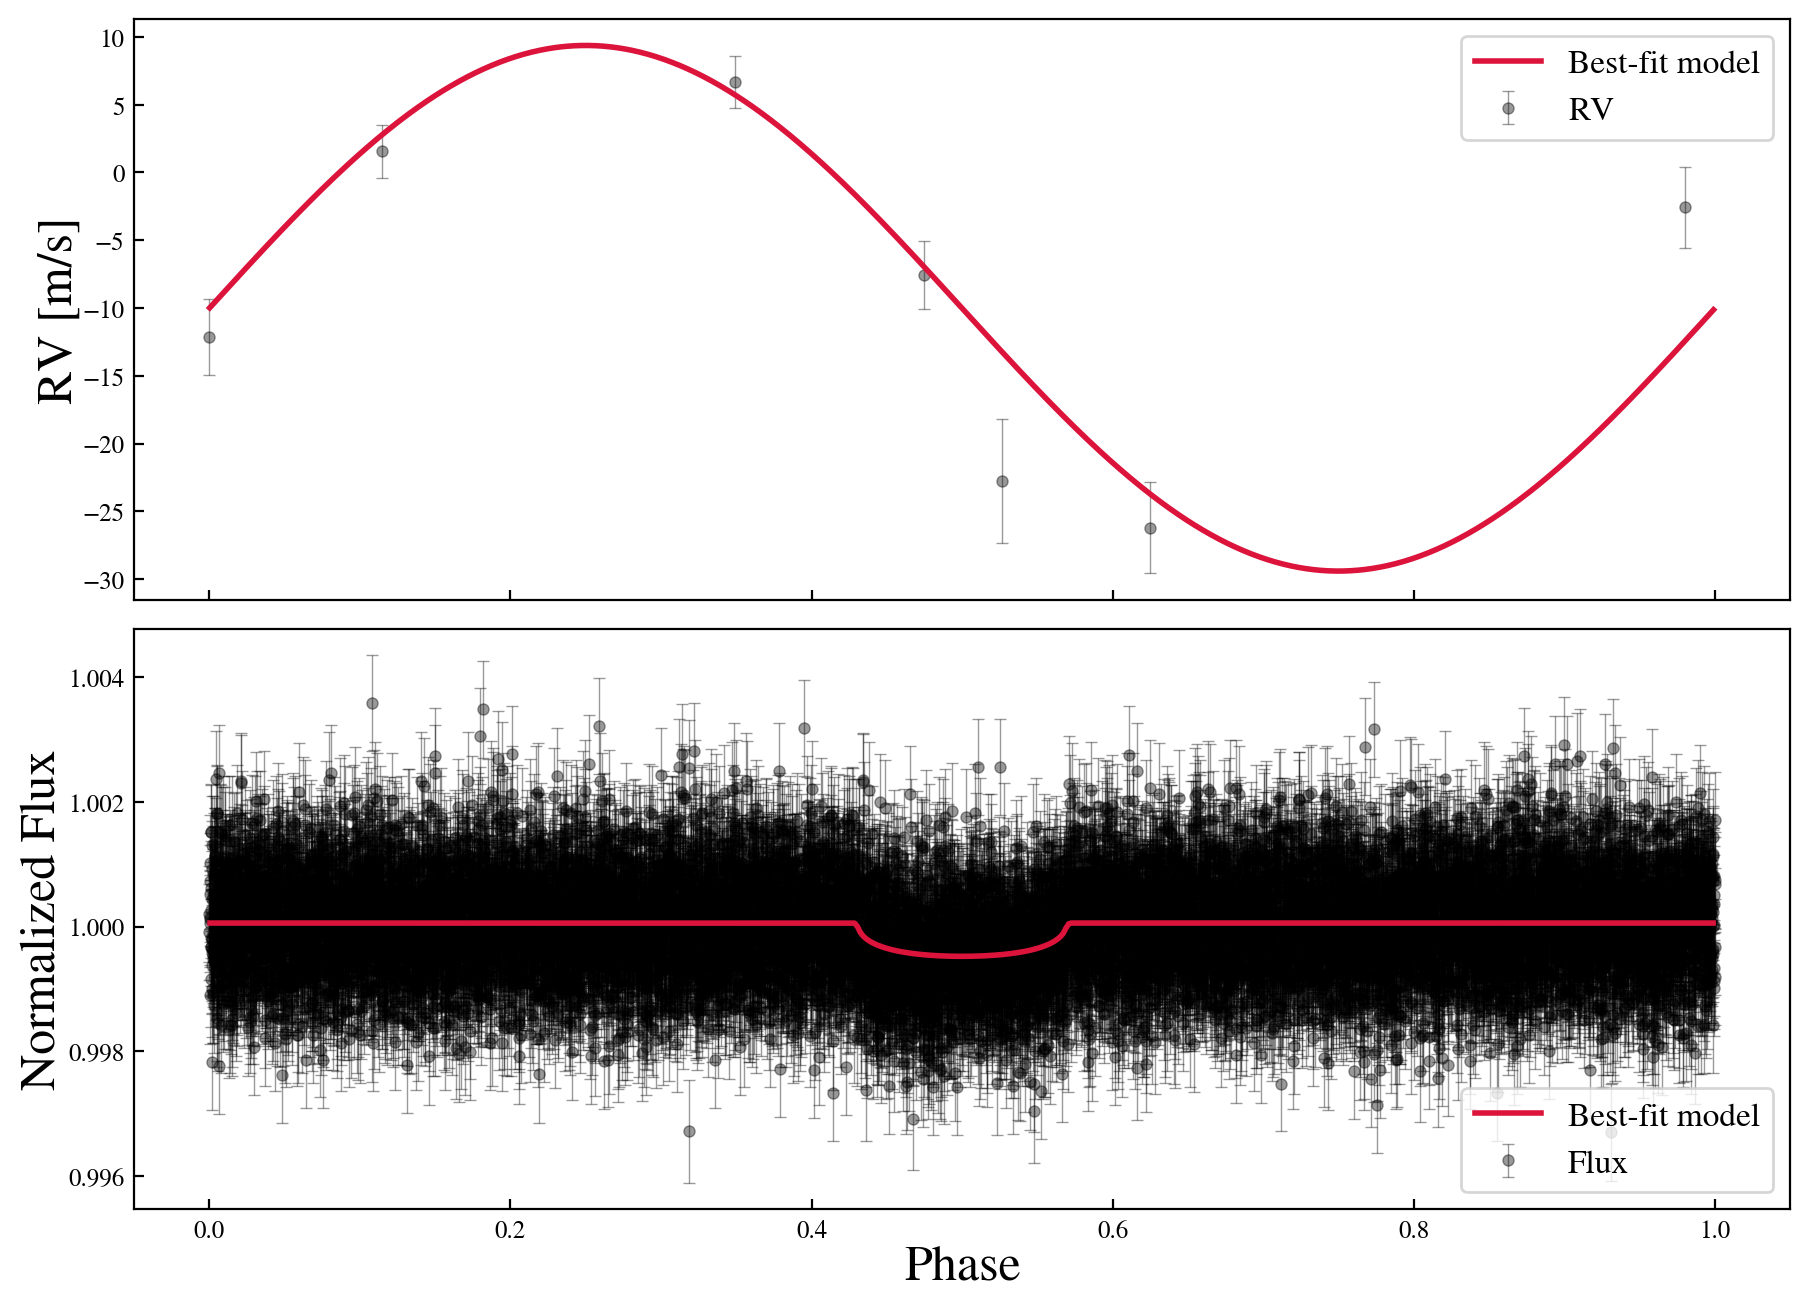

In [32]:
NBIN = 2

#We get the P and T0 values from the MCMC results.
P = df_medvals.medvals.values[df_medvals.Labels=='P_p1'][0]
T_0 = df_medvals.medvals.values[df_medvals.Labels=='t0_p1'][0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0 + 0.5 * P) % P) / P
    
#?????
t01 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_rv1'][0],P,T_0)
t02 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_tr1'][0],P,T_0)

#We define the data color, fit color and the transparency.
markercolor="black"
shadecolor="crimson"
ALPHA=0.4

#We then take the flattened chains.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data_rv1['time'][0]-0.02,TF.lpf.data_rv1['time'][-1]+0.02,500)
times2 = np.linspace(TF.lpf.data_tr1['time'][0]-0.02,TF.lpf.data_tr1['time'][-1]+0.02,500)

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data_rv1["time"], P, T_0)
phase2 = time_to_phase(TF.lpf.data_tr1["time"], P, T_0)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#?????
s1 = 0.
s2 = 0.

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.1,times1.max()+0.1,1000)
t2_mod = np.linspace(times2.min()-0.1,times2.max()+0.1,1000)

#We also convert the times for the model/fit to the orbital phases.
phase_model1 = time_to_phase(t1_mod, P, T_0)
phase_model2 = time_to_phase(t2_mod, P, T_0)

#We compute the Radial Velocities and Fluxes using 50th percentiles i.e. the Model.
rv_50_1, ff_50_1 = TF.lpf.compute_total_model(pv_50,times_rv1=t1_mod,times_tr1=t2_mod)

#We first sort our data according to the Phase values we have.
sorted_indices1 = np.argsort(phase_model1)
phase_model_sorted1 = phase_model1[sorted_indices1]
rv_50_1_sorted = rv_50_1[sorted_indices1]

sorted_indices2 = np.argsort(phase_model2)
phase_model_sorted2 = phase_model2[sorted_indices2]
ff_50_1_sorted = ff_50_1[sorted_indices2]

#?????
gamma1 = TF.lpf.get_jump_parameter_value(pv_50,'gamma_rv1')
#mflux = TF.lpf.get_jump_parameter_value(pv_50,'mflux_tr1')

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(nrows=2,ncols=1,dpi=200,figsize=(9,7),sharex=True)

##################################
# Plot Radial Velocity Data
##################################

# ax.errorbar((TF.lpf.data_rv1['time']-t01)*24,TF.lpf.data_rv1['y'],np.sqrt(TF.lpf.data_rv1['error']**2.+s1**2.),
#             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='RV')

ax.errorbar(phase1,TF.lpf.data_rv1['y'],np.sqrt(TF.lpf.data_rv1['error']**2.+s1**2.),
             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='RV')
ax.plot(phase_model_sorted1,rv_50_1_sorted,color="crimson",
        label='Best-fit model',lw=2.,zorder=10)


##################################
# Plot Transit Data
##################################
# bx.errorbar((TF.lpf.data_tr1['time']-t02)*24,TF.lpf.data_tr1['y'],np.sqrt(TF.lpf.data_tr1['error']**2.+s2**2.),
#             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='Flux')
bx.errorbar(phase2,TF.lpf.data_tr1['y'],np.sqrt(TF.lpf.data_tr1['error']**2.+s2**2.),
             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='Flux')
bx.plot(phase_model_sorted2,ff_50_1_sorted,color="crimson",
        label='Best-fit model',lw=2.,zorder=10)


#################
# Sample models ???????
#################
mmodel1 = []
mmodel2 = []
idx = np.random.choice(range(len(flatchain)),1000)
for i in range(1000):
    if i%100 == 0: print("Sampling, i=",i)
    #idx = #np.random.randint(0, flatchain.shape[0])
    m1,m2 = TF.lpf.compute_total_model(flatchain[idx[i]],times_rv1=t1_mod,times_tr1=t2_mod)
    mmodel1.append(m1)
    mmodel2.append(m2)
mmodel1 = np.array(mmodel1)
mmodel2 = np.array(mmodel2)


#ax.fill_between(phase_model_sorted1,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)

#bx.fill_between(phase_model_sorted2,np.quantile(mmodel2,0.16,axis=0),np.quantile(mmodel2,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.02,axis=0),np.quantile(mmodel2,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.0015,axis=0),np.quantile(mmodel2,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)
    
ax.set_ylabel("RV [m/s]",fontsize=18,labelpad=0)
bx.set_ylabel('Normalized Flux',fontsize=18,labelpad=1)
bx.set_xlabel('Phase',fontsize=18,labelpad=1)

ax.legend(loc='upper right',fontsize=12)

bx.legend(loc='lower right',fontsize=12)

fig.subplots_adjust(wspace=0.02,hspace=0.05,right=0.98,left=0.06,top=0.95,bottom=0.1)

plt.show();

In [33]:
#Adding audio to know the fit has finished.
from IPython.display import Audio

beep = np.sin(2*np.pi*800*np.arange(3000*2)/100000)
Audio(beep, rate=100000, autoplay=True)